# Importação de Bibliotecas 

In [242]:
import pandas as pd
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlencode


%matplotlib inline


base_url = 'https://dadosabertos.camara.leg.br/api/v2//'

# Carregando os Deputados Atuais

Apenda o dataset que deve ser atualizado em *base_url* e recupera os dados.
A resposta da solicitação é escrita no notebook. Se tudo deu certo, o código deve ser 200.

In [243]:
url = base_url + 'deputados'

print('=> Recuperando lista de deputados')
response = requests.get(url)
print(response)

=> Recuperando lista de deputados
<Response [200]>


## Decodificando a resposta  

De-serializar a string de resposta com o objeto dos dados. Utiliza-se a biblioteca **json** para carregar os dados que estão na string *response.text*. O objeto recuperado é um dicionário, com chaves e valores. Pode-se ver que o total de dados recuperados são de 513 elementos, correspondendo os 513 deputados.

In [196]:
obj = json.loads(response.text)
print(obj.__class__)
print(obj.keys())
print(len(obj['dados']))

<class 'dict'>
dict_keys(['dados', 'links'])
513


## Transformar o Objeto em DataFrame 

O **pandas** possui uma forma de recuperar os dados do json para um DataFrame. Dessa forma, os dados podem ser facilmente transportados para o formato tabular.

In [252]:
df_deputados = pd.DataFrame.from_dict(obj['dados'])
print(df_deputados.shape)
df_deputados.rename({'id':'idDeputado'}, axis=1, inplace=True)
print(df_deputados.columns.tolist())
df_deputados.head()

(513, 9)
['email', 'idDeputado', 'idLegislatura', 'nome', 'siglaPartido', 'siglaUf', 'uri', 'uriPartido', 'urlFoto']


,email,idDeputado,idLegislatura,nome,siglaPartido,siglaUf,uri,uriPartido,urlFoto
0,dep.abiliosantana@camara.leg.br,204554,56,Abílio Santana,PL,BA,https://dadosabertos.camara.leg.br/api/v2/depu...,https://dadosabertos.camara.leg.br/api/v2/part...,https://www.camara.leg.br/internet/deputado/ba...
1,dep.abouanni@camara.leg.br,204521,56,Abou Anni,PSL,SP,https://dadosabertos.camara.leg.br/api/v2/depu...,https://dadosabertos.camara.leg.br/api/v2/part...,https://www.camara.leg.br/internet/deputado/ba...
2,dep.acaciofavacho@camara.leg.br,204379,56,Acácio Favacho,PROS,AP,https://dadosabertos.camara.leg.br/api/v2/depu...,https://dadosabertos.camara.leg.br/api/v2/part...,https://www.camara.leg.br/internet/deputado/ba...
3,dep.adolfoviana@camara.leg.br,204560,56,Adolfo Viana,PSDB,BA,https://dadosabertos.camara.leg.br/api/v2/depu...,https://dadosabertos.camara.leg.br/api/v2/part...,https://www.camara.leg.br/internet/deputado/ba...
4,dep.adrianaventura@camara.leg.br,204528,56,Adriana Ventura,NOVO,SP,https://dadosabertos.camara.leg.br/api/v2/depu...,https://dadosabertos.camara.leg.br/api/v2/part...,https://www.camara.leg.br/internet/deputado/ba...


## Links de paginação 

Utilizada para fazer a paginação do resultado. Para recuperar todos os dados, precisa-se iterar sob todas as páginas. Como não há um link com *rel* igual a *next*, entendemos que não tem paginação no resultado.

In [253]:
df_links = pd.DataFrame.from_dict(obj['links'])
df_links

,href,rel
0,https://dadosabertos.camara.leg.br/api/v2/depu...,self
1,https://dadosabertos.camara.leg.br/api/v2/depu...,first
2,https://dadosabertos.camara.leg.br/api/v2/depu...,last


## Como está a distribuição de deputados por partido? 

Podemos utilizar a biblioteca do **seaborn** para fazer algumas análises rápidas.

Text(0.5, 0, '')

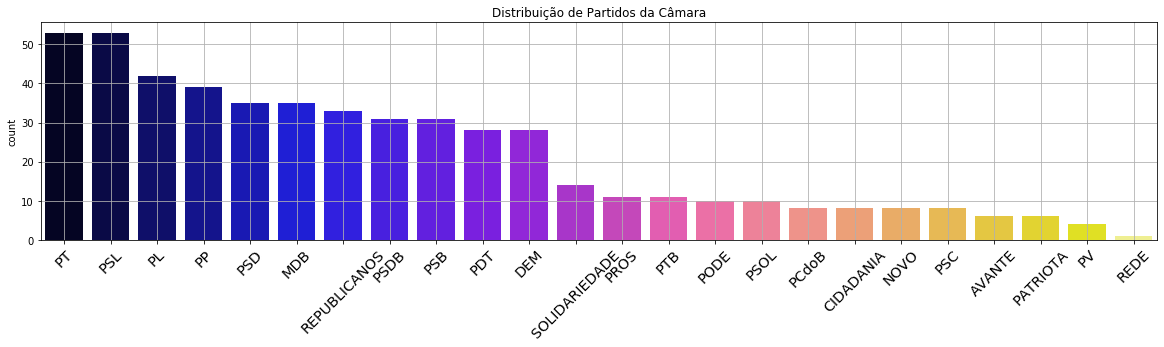

In [66]:
plt.figure(figsize=(20,4))
chart = sns.countplot(x=df_deputados.siglaPartido, palette='gnuplot2',
                      saturation=0.75, ax=None,
                      order=df_deputados.siglaPartido.value_counts().index)
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    fontsize='x-large'

)
plt.title('Distribuição de Partidos da Câmara')
plt.grid()
plt.xlabel("")

## Distribuição de Deputados de Acordo com UF 

Text(0.5, 0, '')

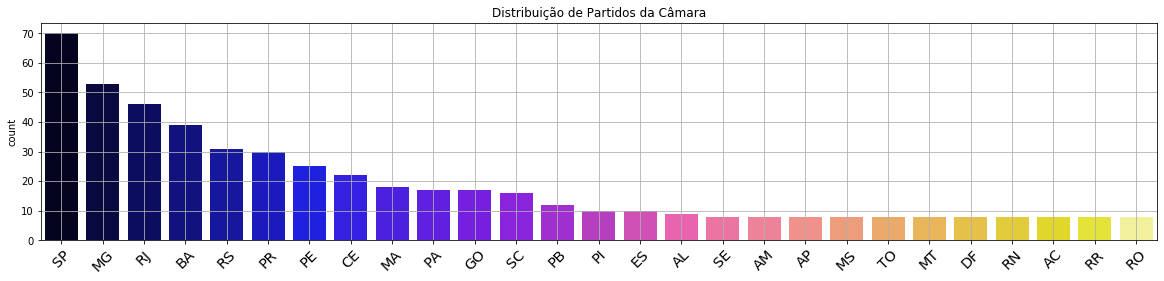

In [67]:
plt.figure(figsize=(20,4))
chart = sns.countplot(x=df_deputados.siglaUf, palette='gnuplot2',
                      saturation=0.75, ax=None,
                      order=df_deputados.siglaUf.value_counts().index)
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    fontsize='x-large'

)
plt.title('Distribuição de Partidos da Câmara')
plt.grid()
plt.xlabel("")

# Recuperar Dados de Despesas dos Deputados 

Algumas queries precisam ser paginadas, pois o resultado não vem completo na mesma resposta. Isso otimiza a comunicação com a API e evita que uma mensagem muito longa seja transportada. Assim, precisa-se iterar sob as páginas retornadas no atributo *links* da resposta.

In [182]:
def get_page_results(url, output_list):
        obj = requests.get(url).json()
        df_data = pd.DataFrame.from_dict(obj['dados'])
        df_links = pd.DataFrame.from_dict(obj['links']).set_index('rel')
        output_list.append(df_data)
        if 'next' in df_links.index:
            get_page_results(df_links.loc['next'].href, output_list)

In [254]:
deputy_expense_list = []
max_n_deputies = -1

for i, id_deputado in enumerate(df_deputados.idDeputado.unique()[:max_n_deputies]):
    print('Coletando os dados do deputado', i+1,'/',df_deputados.idDeputado.nunique())
    params = {
        'ano': 2019,
        'itens': 100
    }
    url = base_url + 'deputados/' + str(id_deputado) + '/despesas'
    url = url + "?" + urlencode(params)
    expense_list = []
    
    get_page_results(url, expense_list)
    df_expense = pd.concat(expense_list)
    df_expense['idDeputado'] = id_deputado
    
    deputy_expense_list.append(df_expense)
    
df_deputy_expenses = pd.concat(deputy_expense_list)

Coletando os dados do deputado 1 / 513


In [229]:
df_deputy_expenses.to_parquet('../../Data/Raw/deputy_expenses.parquet')

In [268]:
group_cols = ['idDeputado','tipoDespesa']
measure_cols={
    'valorLiquido': 'sum',
    'cnpjCpfFornecedor':'nunique',
    'numDocumento':'nunique',
}

df_total_deputy_expenses = df_deputy_expenses.groupby(group_cols).agg(measure_cols).reset_index()
df_results = df_total_deputy_expenses.merge(df_deputados, on='idDeputado', suffixes=['_deputy','_expense'])

# Distribuição de Gastos por Deputado

Text(0.5, 0, 'x Mil (R$)')

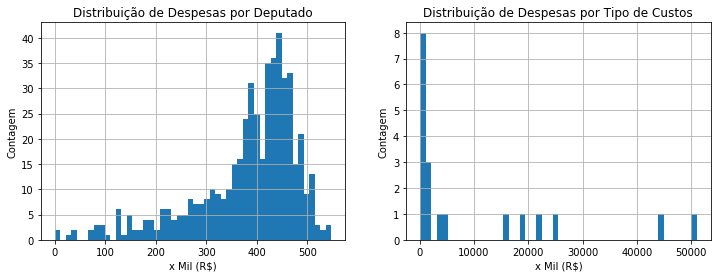

In [278]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
X =  df_results.groupby('nome').valorLiquido.sum().sort_values() * 1e-3
X.hist(bins=50)
plt.title('Distribuição de Despesas por Deputado')
plt.ylabel('Contagem')
plt.xlabel('x Mil (R$)')


plt.subplot(1,2,2)
X =  df_results.groupby('tipoDespesa').valorLiquido.sum().sort_values() * 1e-3
X.hist(bins=50)
plt.title('Distribuição de Despesas por Tipo de Custos')
plt.ylabel('Contagem')
plt.xlabel('x Mil (R$)')


# Top Gastos 

Text(0.5, 0, 'x Mil (R$)')

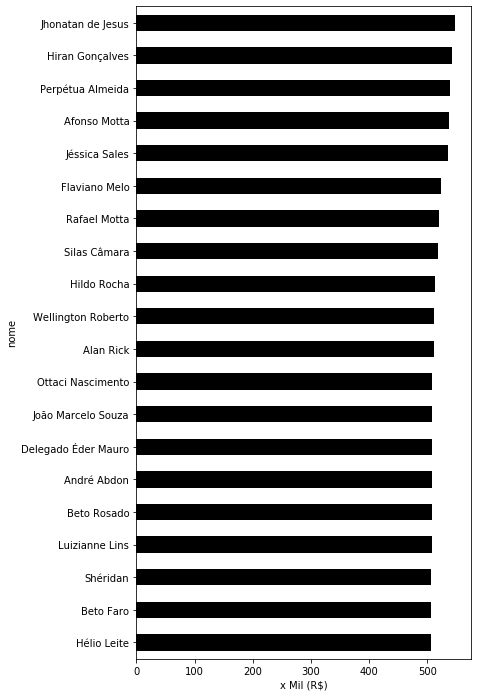

In [235]:

plt.figure(figsize=(6,12))

nshow = 20

X = df_results.groupby('nome').valorLiquido.sum().sort_values() * 1e-3
X.iloc[-nshow:].plot.barh(color='k')
plt.xlabel('x Mil (R$)')

Text(0.5, 0, 'x Mil (R$)')

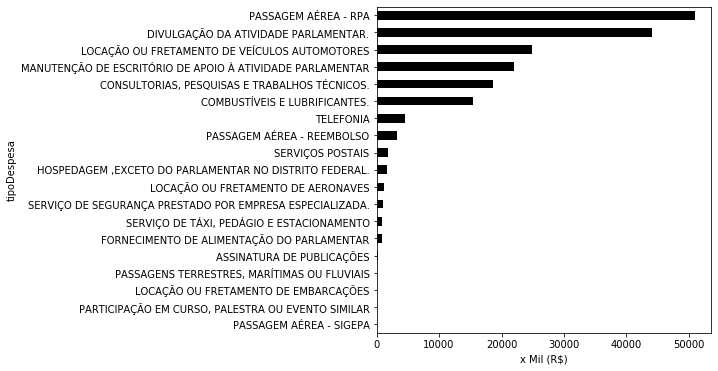

In [239]:
plt.figure(figsize=(6,6))
X = df_results.groupby('tipoDespesa').valorLiquido.sum().sort_values() * 1e-3
X.plot.barh(color='k')
plt.xlabel('x Mil (R$)')